# Goal of this script include:
Process HAADF image to predict sample thickness at each atomic site
<br>Process experiment 4DSTEM data and produce Sr-PACBED
<br>Make prediction using trained CNN on Sr-PACBED
<br>Plot prediction results

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy
import skimage
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import imutils

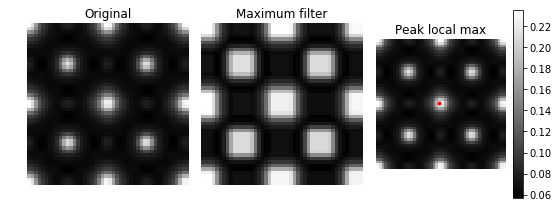

[0.00032587 0.00074156 0.00129999 0.0019182  0.00258037 0.00329554
 0.00405678 0.00483564 0.00553268 0.00621246 0.00684578 0.00748422
 0.00811232 0.00875225 0.00935332 0.0099363  0.01051263 0.01107797
 0.01162776 0.0121038  0.01261048 0.01304462 0.01345218 0.01386417
 0.01426726 0.01460818 0.01496355 0.01531782 0.01565808 0.01600845
 0.01636356 0.01669601 0.01704498 0.01738138 0.01769837 0.01802755
 0.01834558 0.01866404 0.01897411 0.01929716 0.01962067 0.01995378
 0.02028382 0.02061939 0.02095327 0.02127322 0.02160376 0.02192411
 0.02224621 0.02256138 0.02288608 0.02320934 0.02352099 0.02381928
 0.02413749 0.02445897 0.02475997 0.02508758 0.02540787 0.02572817
 0.02603358 0.02636043 0.0266903  0.02702376 0.02734632 0.02765782
 0.02798816 0.02832002 0.02864511 0.02895522 0.02927221 0.02959489
 0.02990411 0.03020363 0.03050726 0.0308225  0.03113143 0.031439
 0.0317355  0.03203285 0.03233623 0.03264671 0.0329622  0.03327223
 0.03356758 0.03387039 0.03414893 0.03444216 0.03473471 0.035027

In [8]:
# Process 2D output covering 112.9 to 353.33 mrad from 100nm model
# Simulation keep using 24.5 mrad convergence angle
# Although new calibration suggesting conv angle should be 25.6mrad instead of 24.5mrad, but change conv angle will require
# change of collection angle at the same time
# For HAADF image, this difference probably won't matter much

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

path = '/srv/home/chenyu/antisite/STO_CL60/CL60_8x8model/'
nslice = 300
source_size = 110
integration_radius = 130
px_size = 17.5

intensity = np.zeros(nslice)

for islice in range(nslice):
    
    name = '_slice' + str(islice) + '_'
    file_2D = [image for image in os.listdir(path) if '2Doutput' and name in image]
    file_2D = file_2D[0]
#     print(file_2D)
    image_2D = loadMRCfile(path + file_2D)

#     im = img_as_float(Convolution_2D(image,source_size))
    im = skimage.img_as_float(image_2D)

    # image_max is the dilation of im with a 5x5 structuring element
    # It is used within peak_local_max function
    image_max = ndi.maximum_filter(im, size=5, mode='constant')

    # Comparison between image_max and im to find the coordinates of local maxima
    # min_distance = 20 will find only the Sr peak at center
    # Peak positions are found in integers
    coordinates = peak_local_max(im, min_distance=20)
#     print(coordinates)
    
    center = [coordinates[0,0], coordinates[0,1]]
    circular_mask = create_circular_mask(im.shape[0],im.shape[1],center, integration_radius/px_size)
    
    # Intensity is a list of averaged intensity inside the Sr mask
    intensity[islice] = (im*circular_mask).sum()/circular_mask.sum()
    
# Display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

im2 = ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
fig.colorbar(im2,ax=ax[2])

fig.tight_layout()

plt.show()
print(intensity)

## Wrapper after HAADF simulation loaded

1.3622663306848948 -1.50591889536559


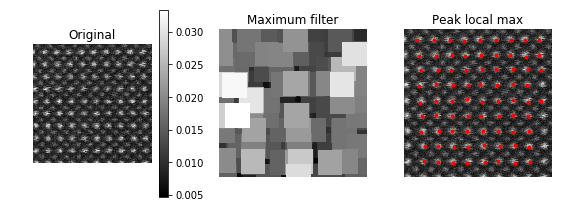

[26. 25. 25. 24. 26. 24. 24. 23. 27. 25. 25. 25. 25. 25. 25. 27. 24. 27.
 26. 26. 28. 26. 29. 28. 25. 22. 25. 24. 25. 25. 23. 26. 28. 27. 23. 24.
 25. 26. 28. 27. 26. 26. 24. 23. 24. 24. 26. 23. 26. 25. 25. 25. 25. 26.
 24. 23. 23. 25. 27. 26. 28. 28. 27. 26. 26. 27. 27. 26. 26. 28. 24. 26.
 28. 25. 26. 26.]
Now working on radius: 1
Now working on radius: 2
Now working on radius: 3
Now working on radius: 4
Now working on radius: 5
Now working on radius: 6
Now working on radius: 7
Now working on radius: 8
Now working on radius: 9
Now working on radius: 10


FileNotFoundError: [Errno 2] No such file or directory: '/srv/home/chenyu/DEbackup/061619/S8/npy/S8_-0011.npy'

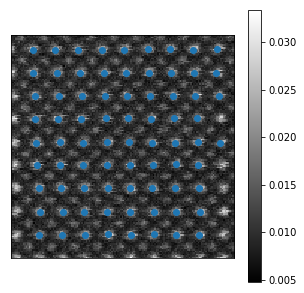

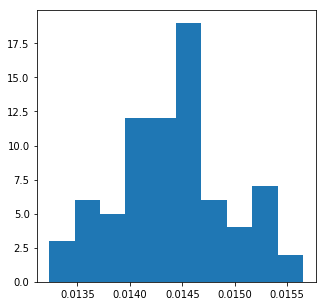

In [27]:
# DetectorScan = '/srv/home/chenyu/DEbackup/033119/HAADF_Preview_1000_1000_3_17_32_PM.csv'
# FullProcess('/srv/home/chenyu/DEbackup/033119/S5/','S5', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/033119/S6/','S6', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/033119/S8/','S8', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/033119/S9/','S9', DetectorScan)
# DetectorScan = '/srv/home/chenyu/DEbackup/010619/DetectorScan/HAADF_Preview_1000_1000_2_33_03_PM.csv'
# FullProcess('/srv/home/chenyu/DEbackup/010619/S1/','S1', DetectorScan)
# # FullProcess('/srv/home/chenyu/DEbackup/010619/S2/','S2', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/010619/S3/','S3', DetectorScan)
# # FullProcess('/srv/home/chenyu/DEbackup/010619/S4/','S4', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/010619/S5/','S5', DetectorScan)
# # FullProcess('/srv/home/chenyu/DEbackup/010619/S6/','S6', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/010619/S7/','S7', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/010619/S8/','S8', DetectorScan)
# DetectorScan = ('/srv/home/chenyu/DEbackup/012119/LinearityTest_C41.093_B39.584_4Vrange/SS9_APT70/HAADF_Preview_512_512_2_20_41_PM.csv')
# FullProcess('/srv/home/chenyu/DEbackup/022119/S1/','S1', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S2/','S2', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S3/','S3', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S4/','S4', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S5/','S5', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S6/','S6', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S7/','S7', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S8/','S8', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/022119/S9/','S9', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/012119/S1/','S1', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/012119/S2/','S2', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/012119/S3/','S3', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/012119/S4/','S4', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/012119/S5/','S5', DetectorScan)
# DetectorScan = ('/srv/home/chenyu/DEbackup/2018/071618/DetectorScan/HAADF_Preview_200_200_3_13_43_PM.csv')
# FullProcess('/srv/home/chenyu/DEbackup/2018/071618/S7/','S7', DetectorScan)
DetectorScan = '/srv/home/chenyu/DEbackup/061619/DetectorScan/HAADF_Preview_512_512_4_24_28_PM.csv'
# FullProcess('/srv/home/chenyu/DEbackup/061619/S3/','S3', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/061619/S4/','S4', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/061619/S5/','S5', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/061619/S6/','S6', DetectorScan)
# FullProcess('/srv/home/chenyu/DEbackup/061619/S7/','S7', DetectorScan)
FullProcess('/srv/home/chenyu/DEbackup/061619/S8/','S8', DetectorScan)

In [23]:
def FullProcess(path, name, DetectorScan):
    (coordinates, HAADF)=ProcessHAADF(path, DetectorScan)
    LocatePeaks(path,coordinates, HAADF)
    EstimateThickness(path, HAADF)
    GeneratePACBED(path,name)
    print(path + ' finished.')

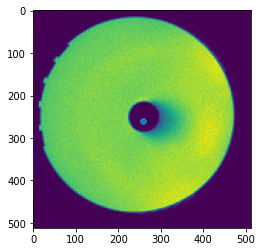

In [9]:
path = '/srv/home/chenyu/DEbackup/061219/DetectorScan/'
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(512,512))
plt.imshow(HAADFarray)
plt.scatter(258,261)

1.3622663306848948 -1.50591889536559


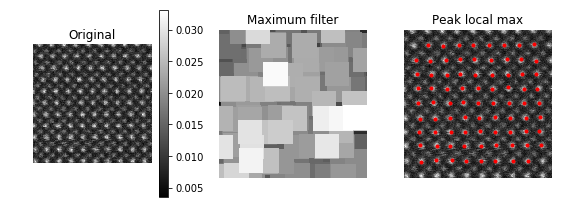

[24. 23. 23. 23. 23. 22. 25. 24. 24. 23. 26. 26. 24. 25. 26. 24. 25. 23.
 22. 24. 23. 26. 22. 21. 24. 22. 24. 25. 25. 23. 23. 23. 24. 24. 24. 23.
 24. 22. 23. 21. 22. 23. 23. 23. 24. 23. 24. 23. 22. 24. 23. 24. 22. 23.
 24. 23. 24. 24. 24. 23. 25. 23. 22. 24. 24. 24. 22. 24. 24. 23. 23. 22.
 24. 21. 22. 22. 23. 22. 23.]
Now working on radius: 1
Now working on radius: 2
Now working on radius: 3
Now working on radius: 4
Now working on radius: 5
Now working on radius: 6
Now working on radius: 7
Now working on radius: 8
Now working on radius: 9
Now working on radius: 10
Now working on radius: 11


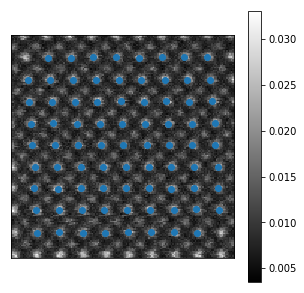

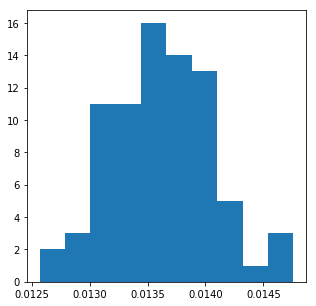

In [22]:
# DetectorScan = '/srv/home/chenyu/DEbackup/033119/HAADF_Preview_1000_1000_3_17_32_PM.csv'
# DetectorScan = ('/srv/home/chenyu/DEbackup/012119/LinearityTest_C41.093_B39.584_4Vrange/SS9_APT70/HAADF_Preview_512_512_2_20_41_PM.csv')
DetectorScan = '/srv/home/chenyu/DEbackup/061619/DetectorScan/HAADF_Preview_512_512_4_24_28_PM.csv'
(coordinates, HAADF)=ProcessHAADF('/srv/home/chenyu/DEbackup/061619/S2/', DetectorScan)
LocatePeaks('/srv/home/chenyu/DEbackup/061619/S2/',coordinates, HAADF)
EstimateThickness('/srv/home/chenyu/DEbackup/061619/S2/',HAADF)
GeneratePACBED('/srv/home/chenyu/DEbackup/061619/S2/', 'S2')

In [10]:
def ProcessHAADF(path, DetectorScan):

    # Load experimentally collected HAADF data and detect peaks

#     path = '/srv/home/chenyu/DEbackup/033119/S3/'

    # Thickness prediction part adapted from Quant4DSTEM

    file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
    file_HAADF = file_HAADF[0]
    with open(path +  file_HAADF) as csvfile:
        file=csv.reader(open(path+file_HAADF,'r'))
        n=[]
        for row in file:
            n.append(row)

    HAADFarray = np.transpose(np.asarray(n))
    HAADFarray = np.squeeze(HAADFarray)
    HAADFarray = HAADFarray.astype(np.float)
    HAADFarray = np.reshape(HAADFarray,(150,150))

    (BeamLevel, DarkLevel_0) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/012119/LinearityTest_C41.093_B39.584_4Vrange/SS9_APT70/HAADF_Preview_512_512_2_20_41_PM.csv',512)
    (BeamLevel, DarkLevel) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/033119/HAADF_Preview_1000_1000_3_17_32_PM.csv',1000)
    (BeamLevel, DarkLevel) = BeamLevelCalibrate(DetectorScan,512)
    #     (BeamLevel, DarkLevel) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/010619/DetectorScan/HAADF_Preview_1000_1000_2_33_03_PM.csv',1000)
    print(BeamLevel,DarkLevel)
#     print(DarkLevel_0)
    #     DarkLevel = -1.505
    #     BeamLevel = 0.6759
    #     DarkLevel = -1.0867
    HAADFarray = (HAADFarray - DarkLevel)/(BeamLevel - DarkLevel)

    im = img_as_float(np.reshape(HAADFarray,(150,150)))
#     im = im - np.amin(im)
    image_max = ndi.maximum_filter(im, size=25, mode='constant')

    coordinates = peak_local_max(im, min_distance=10)

    center = [coordinates[0,0], coordinates[0,1]]

    fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    im0 = ax[0].imshow(im, cmap=plt.cm.gray)
    fig.colorbar(im0,ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title('Original')

    ax[1].imshow(image_max, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('Maximum filter')

    ax[2].imshow(im, cmap=plt.cm.gray)
    ax[2].autoscale(False)
    ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    ax[2].axis('off')
    ax[2].set_title('Peak local max')

    fig.tight_layout()

    plt.show()
    
    return (coordinates, HAADFarray)

In [13]:
def LocatePeaks(path, coordinates, im):
    # Fit positions of each peak

    peaks_x_fit = []
    peaks_y_fit = []
    for i in range(coordinates.shape[0]):

        x = int(coordinates[i][1])
        y = int(coordinates[i][0])

        patch = im[y-7:y+7,x-7:x+7]
        bg = np.amin(patch)
        guess = (bg,patch[7,7]-bg,7, 7, 3, 3)
        bounds = ([min(0,bg),0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
#         print(bounds)
#         print(guess)
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-7)
        peaks_y_fit.append(param[3]+y-7)

    fig = plt.figure(figsize=(5,5))
    im0 = plt.imshow(im,cmap=plt.cm.gray)
    fig.colorbar(im0)
    plt.scatter(peaks_x_fit,peaks_y_fit)
    plt.xticks([])
    plt.yticks([])

    peaks_x_fit = np.asarray(peaks_x_fit)
    peaks_y_fit = np.asarray(peaks_y_fit)
    np.save(path +'SrPeaks_x.npy',np.asarray(peaks_x_fit))
    np.save(path +'SrPeaks_y.npy',np.asarray(peaks_y_fit))

In [17]:
def EstimateThickness(path,im):

# Determine thickness of each atomic site
    integration_radius = 130
    px_size = 24.7

    peaks_x_fit = np.load(path + 'SrPeaks_x.npy')
    peaks_y_fit = np.load(path + 'SrPeaks_y.npy')

    thickness_list = np.zeros(peaks_x_fit.shape[0])
    intensity_list = np.zeros(peaks_x_fit.shape[0])
    for i in range(peaks_x_fit.shape[0]):
        center = [peaks_x_fit[i],peaks_y_fit[i]]
        circular_mask = create_circular_mask(im.shape[0],im.shape[1],center, integration_radius/px_size)
        intensity_list[i] = (im*circular_mask).sum()/circular_mask.sum()  # Checked position of mask, right on atom
        thickness_list[i] = argmin(np.absolute(intensity - intensity_list[i]))+1 # have 1 uc offset, intensity[0] corresponds to 1 uc

    np.save(path + 'SrPeaks_thickness.npy',np.asarray(thickness_list))
    fig = plt.figure(figsize=(5,5))
    plt.hist(intensity_list)
    print(thickness_list)

In [15]:
def GeneratePACBED(path, name):

    # Coonstruct PACBED from corresponding peak and save them into a stack.
    # No need to create quantitative PACBED for this.
    # Loop over all peaks detected from HAADF under different integration radii to construct PACBED stack

    # path = '/srv/home/chenyu/DEbackup/033119/S2/'
    # name = 'S2'
    peaks_x = np.load(path + 'SrPeaks_x.npy')
    peaks_y = np.load(path + 'SrPeaks_y.npy')
    # BF = np.load(path + name + 'BF.npy')
    thickness = np.load(path + 'SrPeaks_thickness.npy')
    radius_list = np.array([1,2,3,4,5,6,7,8,9,10,11])
    PACBED_size = (512,512)

    for iradius in range(len(radius_list)):
        print('Now working on radius: ' + str(radius_list[iradius]))
        radius = radius_list[iradius]
        PACBED_stack = np.zeros((PACBED_size[0],PACBED_size[1],peaks_x.size))

        for iColumn in range(peaks_x.size):

            # Select one column to do the test
    #         iColumn = 15
    #         radius = 10

            layer = int(thickness[iColumn])
    #         print('Column '+str(iColumn)+' has ' + str(layer)+' layers.')
            x = peaks_x[iColumn]
            y = peaks_y[iColumn]
    #         print(x,y)
            x = np.round(x)
            y = np.round(y)
    #         print(x,y)

            # Quantitative experiment PACBED

    #         PACBED_exp = np.zeros((512,512))
            expMask = create_circular_mask(radius*2+1,radius*2+1,center=[radius,radius])
            px_list = np.nonzero(expMask)
            # row for non-zero pixels
            row_list = px_list[0] + y - radius
            col_list = px_list[1] + x - radius

            # Directly visulize pixels used to generate PACBED
        #     plt.subplot(121)
        #     plt.imshow(BF[1:-1,:])
        #     plt.scatter(col_list,row_list)
        #     plt.scatter(x,y)
        #     plt.axis('off')

            file_list= row_list*150+col_list+1

            for ifile in range(file_list.size):
                frame = np.load(path + 'npy/'+ name +'_'+format(int(file_list[ifile]),'05')+'.npy')
    #             frame = frame/BeamLevel
                PACBED_stack[:,:,iColumn] = PACBED_stack[:,:,iColumn] + frame

            PACBED_stack[:,:,iColumn] = PACBED_stack[:,:,iColumn] / file_list.size

        #     plt.subplot(122)
        #     plt.imshow(PACBED_exp)
        #     plt.axis('off')

        np.save(path +'PACBED_stack_radius_' + str(radius) + '.npy',PACBED_stack)

## Aux functions

In [3]:
def BeamLevelCalibrate(path,size):
    center = [258,261]
    mask = create_circular_mask(size,size, center, 5)
    with open(path) as csvfile:
        file=csv.reader(open(path,'r'))
        Beam = []
        Dark = []
        n=[]
        for row in file:
            n.append(row)
            
    HAADFarray = np.transpose(np.asarray(n))
    HAADFarray = np.squeeze(HAADFarray)
    HAADFarray = HAADFarray.astype(np.float)
    DetectorScan = np.reshape(HAADFarray,(size,size))
    
    DarkLevel = DetectorScan[np.nonzero(DetectorScan*mask)].mean()
    DarkLevel = np.amin(DetectorScan)
    BeamLevel = DetectorScan[np.nonzero(np.heaviside(DetectorScan,0))].mean()

    return(BeamLevel,DarkLevel)

In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [5]:
import struct
import mrcfile
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time

def loadMRCfile(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(8)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        image = np.zeros((frame_height,frame_width))
        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*4)
        for irow in range(frame_height):
            for icol in range(frame_width):
                pixel = struct.unpack('<f',dataset[(irow*frame_width+icol)*4:(irow*frame_width+icol+1)*4])[0]
                image[irow,icol] = pixel
        return image

In [6]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [7]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

## To reply reviewer's comments and generate PACBED from in between area

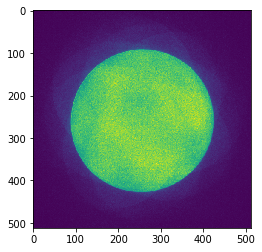

In [31]:
temp = np.load('/srv/home/chenyu/DEbackup/2019/022119/S3/PACBED_stack_radius_7.npy')
plt.imshow(temp[:,:,10])